## Building Binary Trees

In [1]:
from imports import *
np.random.seed(20090403)

We first consider the dyadic binary tree on 64 nodes:

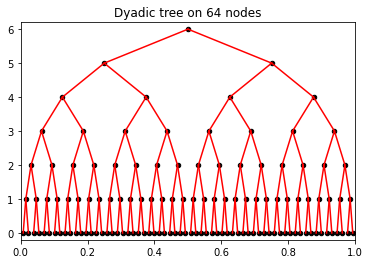

In [2]:
dyadic_64 = tree.dyadic_tree(6)
plot_tree(dyadic_64,title="Dyadic tree on 64 nodes")

Let each point of this tree be at a location $x_i$ equal to its index (so 0 through 63). We generate a toy affinity for demonstration purposes by taking $A(i,j) \sim \exp{\left(-\frac{\left|{x_i-x_j}\right|^2}{100}\right)}$. We further consider a random permutation of the points, $A_p$, and plot the strength of the affinities $A$ and $A_p$ (white is stronger affinity).

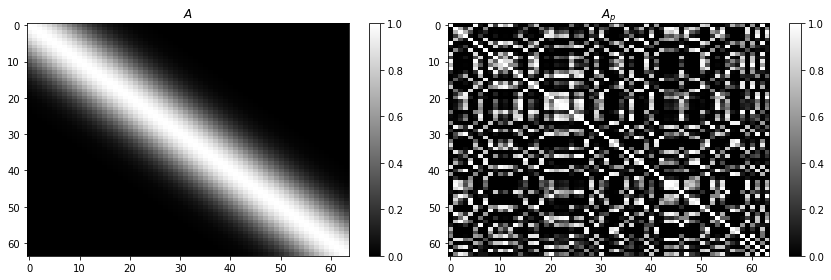

In [4]:
A = np.zeros([64,64])
for i in range(64):
    for j in range(64):
        d_ij = (i-j)
        A[i,j] = np.exp(-(d_ij**2.0/100.0))
row_order = np.random.rand(64).argsort()
A_p = A[row_order,:][:,row_order]
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
bwplot(A,colorbar=True,title="$A$")
fig.add_subplot(122)
bwplot(A_p,colorbar=True,title="$A_p$")
plt.tight_layout()
plt.show()

### Eigenvector Cuts

We next construct binary trees on $A$ and $A_p$. To provide a sense of how the binary cutting process works, we look at the cuts made on the diffusion embedding at diffusion time 1 for the largest few nodes in the tree built on $A$. The nodes are colored by the split at that level.

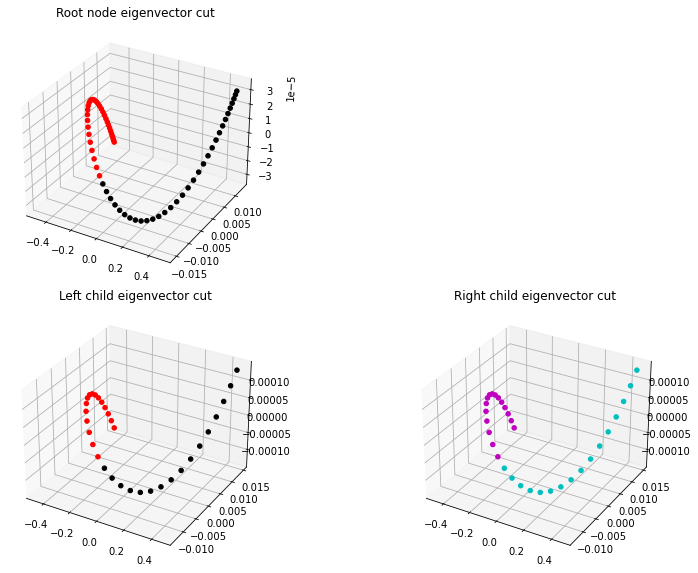

In [5]:
bt1 = bin_tree_build.bin_tree_build(A,"r_dyadic",1.0)
bt2 = bin_tree_build.bin_tree_build(A_p,"r_dyadic",1.0)
lchild = bt1.children[0]
rchild = bt1.children[1]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221,projection="3d")
ax2 = fig.add_subplot(223,projection="3d")
ax3 = fig.add_subplot(224,projection="3d")

#compute the top few eigenvectors.
vecs,vals = markov.markov_eigs(A,4)
partition = bt1.level_partition(2)
plot_embedding(vecs,vals,partition=partition,ax=ax1)
vecs,vals = markov.markov_eigs(A[lchild.elements,:][:,lchild.elements],4)
partition = np.array(bt1.level_partition(3))[lchild.elements]
plot_embedding(vecs,vals,partition=partition,ax=ax2)
vecs,vals = markov.markov_eigs(A[rchild.elements,:][:,rchild.elements],4)
partition = np.array(bt1.level_partition(3))[rchild.elements]
plot_embedding(vecs,vals,partition=partition,ax=ax3)

ax1.set_title("Root node eigenvector cut")
ax2.set_title("Left child eigenvector cut")
ax3.set_title("Right child eigenvector cut")

plt.tight_layout()
plt.show()

Next we display the trees. We color the leaf nodes on a gradient from 0 to 63 (from $A$) to show the organization of leaves present in the binary trees.

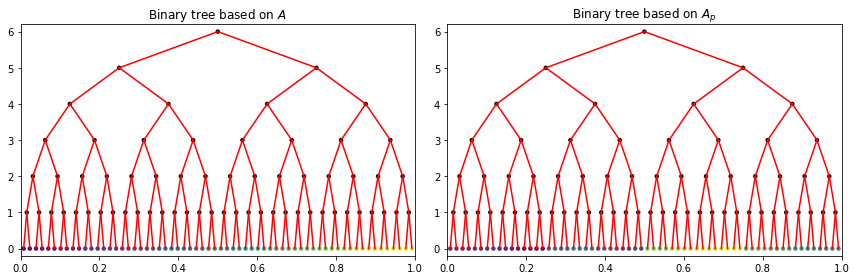

In [6]:
leafcolors = np.arange(-1.0,1.0,2.0/64.0)
fig=plt.figure(figsize=(12,4))
fig.add_subplot(121)
plot_tree(bt1,leafcolors=leafcolors,title="Binary tree based on $A$")
fig.add_subplot(122)
plot_tree(bt2,leafcolors=leafcolors[row_order],
          title="Binary tree based on $A_p$")
plt.tight_layout()
plt.show()

Notice that in the tree built on $A_p$, the precise gradient is lost. However, with regard to the tree metric, these trees are exactly equivalent, and can be rearranged to match the original tree without any loss of information. In the tree metric, once a split occurs, the internal organization of one of the child nodes is completely irrelevant to nodes outside that child. This can be seen by matching the distance matrix from one tree to the other (after undoing the permutation).

In [9]:
inverse_row_order = row_order.argsort()
tree_distances = np.zeros(A.shape)
tree_distances_p = np.zeros(A.shape)
for i in range(64):
    for j in range(64):
        tree_distances[i,j] = bt1.tree_distance(i,j)
        tree_distances_p[i,j] = bt2.tree_distance(inverse_row_order[i],
                                                  inverse_row_order[j])
np.allclose(tree_distances,tree_distances_p)

True

### Perturbing the Trees For Spin Cycling

We next demonstrate the other trees discussed in this section. In the dyadic case, the binary splits occur at the median. We can also split the node into two groups at the point where the eigenvector coordinates change sign. Because of the neat symmetry of the original data, splitting $A$ at zero reproduces the original tree exactly. Hence we introduce a slightly noisy version of $A$ by $A_{noise} = (0.9)A + (0.1)U$, where the entries of $U$ are uniform on $\left[0,1\right]$. We then generate the zero-split tree on $A_{noise}$.

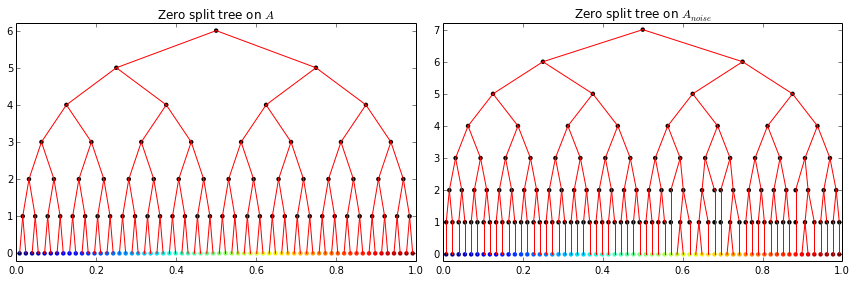

In [7]:
bt3 = bin_tree_build.bin_tree_build(A,"zero")
A_noise = A*0.90 + np.random.rand(64,64)*0.1
bt4 = bin_tree_build.bin_tree_build(A_noise,"zero")
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plot_tree(bt3,leafcolors=leafcolors,title='Zero split on $A$')
fig.add_subplot(122)
plot_tree(bt4,leafcolors=leafcolors,title='Zero split on $A_{noise}$')
plt.tight_layout()
plt.show()

This method (see the tree on the right) introduces a perturbation on the trees that can be desirable for cleaning up artifacts and smoothing boundaries. Finally, we can produce more of this slight randomization by building random dyadic trees. We choose a balance constant (here 1.5), and we can generate many trees which are slight perturbations of each other, but which preserve the overall structure quite well:

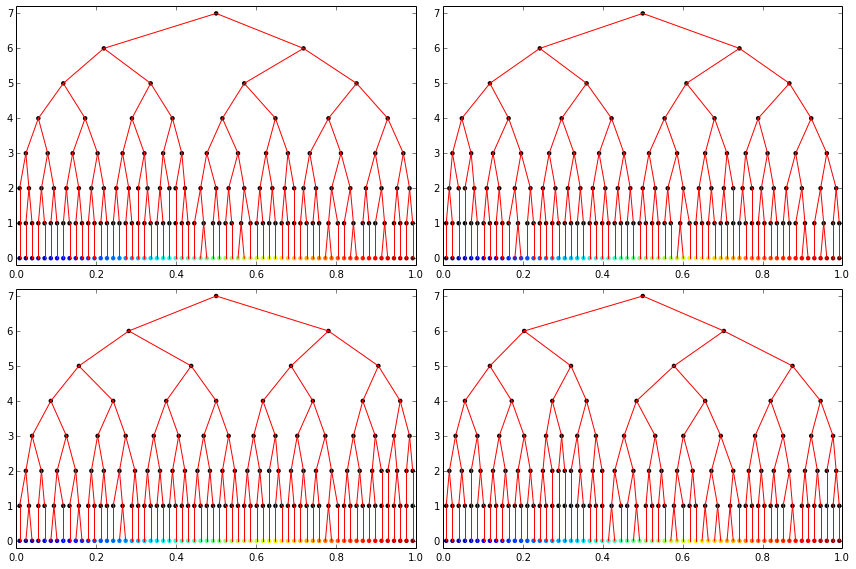

In [8]:
fig = plt.figure(figsize=(12,8))
for i in xrange(4):
    fig.add_subplot(2,2,i+1)
    bt = bin_tree_build.bin_tree_build(A,"r_dyadic",1.5)
    plot_tree(bt,leafcolors=leafcolors)
plt.tight_layout()
plt.show()